This notebook is designed to investigate better fit functions for response in different pT bins, wiht a focus on low pT(Ref) bins.

We try to find a better fit function at low pT, then see if it can also be applied to higher pT bins.

Note that this uses data from Spring15 MC, without Layer1 JEC, without L1JEC.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

import numpy as np
import scipy.stats
from scipy.optimize import minimize

from collections import OrderedDict
import math
from itertools import izip
from copy import deepcopy

In [33]:
mpl.rcParams['figure.figsize'] = (9.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

In [34]:
%config InlineBackend.figure_format='svg'
# %config InlineBackend.figure_format='retina'

# Get data

Get data from txt files - just a list of responses that fall into two $p_T^{Ref}$ bins.

In [4]:
txt_filename = ("rsp_ptRef10to14_clean.txt")

with open(txt_filename) as f:
    rspLow = [float(x) for x in f]

In [5]:
rspLow = np.array(rspLow)
rspLowInv = 1./rspLow

In [6]:
txt_filename = ("rsp_ptRef102to106_clean.txt")

with open(txt_filename) as f:
    rspHigh = [float(x) for x in f]

In [7]:
rspHigh = np.array(rspHigh)
rspHighInv = 1./rspHigh

# Scipy fit functions

Note that we can find a fit for response **or** 1/response - it doesn't matter, since we can transform to either space trivially via the Jacobian. We'll try both, for both pT(Ref) bins.

## Lower ptRef bin (10  - 14 Gev) 

##  response

These are a subset of all the `continuous_rv` functions in scipy (I've left out the very very slow ones, and the ones that give stupid fits).

In [13]:
fit_fns =  OrderedDict()
fit_fns["Beta"] = dict(fn=scipy.stats.beta)
fit_fns["Betaprime"] = dict(fn=scipy.stats.betaprime)
fit_fns["Burr Type 3"] = dict(fn=scipy.stats.burr)
fit_fns["Chi"] = dict(fn=scipy.stats.chi)
fit_fns["Chi2"] = dict(fn=scipy.stats.chi2)
fit_fns["Exponnorm"] = dict(fn=scipy.stats.exponnorm)
fit_fns["Exponweib"] = dict(fn=scipy.stats.exponweib)
fit_fns["F"] = dict(fn=scipy.stats.f)
fit_fns["Fatiguelife"] = dict(fn=scipy.stats.fatiguelife)
fit_fns["Fisk"] = dict(fn=scipy.stats.fisk)
fit_fns["Frechet_l"] = dict(fn=scipy.stats.frechet_l)
fit_fns["Genlogistic"] = dict(fn=scipy.stats.genlogistic)
fit_fns["Genextreme"] = dict(fn=scipy.stats.genextreme)
fit_fns["Gamma"] = dict(fn=scipy.stats.gamma)
fit_fns["Gengamma"] = dict(fn=scipy.stats.gengamma)
fit_fns["Gumbel_r"] = dict(fn=scipy.stats.gumbel_r)
fit_fns["Invgamma"] = dict(fn=scipy.stats.invgamma)
fit_fns["Invgauss"] = dict(fn=scipy.stats.invgauss)
fit_fns["Invweibull"] = dict(fn=scipy.stats.invweibull)
fit_fns["Johnsonsb"] = dict(fn=scipy.stats.johnsonsb)
fit_fns["Johnsonsu"] = dict(fn=scipy.stats.johnsonsu)
fit_fns["Kstwobign"] = dict(fn=scipy.stats.kstwobign)
fit_fns["Lognorm"] = dict(fn=scipy.stats.lognorm)
fit_fns["Mielke"] = dict(fn=scipy.stats.mielke)
fit_fns["Norm"] = dict(fn=scipy.stats.norm)
fit_fns["Pearson3"] = dict(fn=scipy.stats.pearson3)
fit_fns["Powerlognorm"] = dict(fn=scipy.stats.powerlognorm)
fit_fns["Rayleigh"] = dict(fn=scipy.stats.rayleigh)
fit_fns["Rice"] = dict(fn=scipy.stats.rice)
fit_fns["Recipinvgauss"] = dict(fn=scipy.stats.recipinvgauss)
fit_fns["Weibull_max"] = dict(fn=scipy.stats.weibull_max)

In [14]:
def get_bin_centers(bins):
    return np.array([0.5 * (bins[i]+bins[i+1]) for i in range(len(bins)-1)])

In [22]:
def plot_multiple_fits(data, fit_fns, x_label, x_range, n_fit_std=10):
    """Plot multiple fits to the data, show all.

    data: numpy.array. Data to fit to. 
    fit_fns: dict[name, dict]. Function to fit, and name.
    x_label: str. Label for x axis
    x_range: list[min, max]. Range of x axis
    """
    ncols = 3
    nrows = int(math.ceil(len(fit_fns)/2.))
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    plt.subplots_adjust(hspace=0.5)

    x_val = np.linspace(x_range[0], x_range[1], 100)

    for i_plt, (fn_name, fit_fn_dict) in enumerate(fit_fns.iteritems(), 1):
        print "Doing", fn_name
        #         if i_plt == 2:
#             break
        plt.subplot(nrows, ncols, i_plt)
        ax = plt.gca()
        ax.set_title(fn_name + ' fit')
        ax.set_xlabel(x_label)

        # apply optional cut to data
        mean = data.mean()
        std = data.std()
        mask = (data < mean + (std*n_fit_std)) & (data > mean-(std*n_fit_std))
        data = data[mask]
#         ax.set_yscale('log')

        # plot hist
        n, bins, patches = ax.hist(data, bins=40, range=x_range, normed=True)

        # fit
        try:
            fit_results = fit_fn_dict['fn'].fit(data)
        except NotImplementedError:
            continue
        print fit_results
        has_shape_param = len(fit_results) >= 3
        loc = fit_results[-2]
        scale = fit_results[-1]
        shape = None
        if has_shape_param:
            shape = fit_results[:-2]

        fit_fn_dict['shape'] = shape
        fit_fn_dict['loc'] = loc
        fit_fn_dict['scale'] = scale
            
        if has_shape_param:
            frozen_fit = fit_fn_dict['fn'](*shape, loc=loc, scale=scale)
        else:
            frozen_fit = fit_fn_dict['fn'](loc=loc, scale=scale)
        
        # get mode for fitted fn
        ave = 0.5*(x_range[0]+x_range[1])
        max_result = minimize(lambda x: -1. * frozen_fit.pdf(x), x0=ave)
        mode = max_result.x[0]

        # get mode for proper fn for (1/x) - include jacobian
        max_result_inv = minimize(lambda x: -1. * np.power(1./x, 2) * frozen_fit.pdf(1./x), x0=1./ave)
        mode_inv = max_result_inv.x[0]
        
        # do chi2 test
        bc = get_bin_centers(bins)
        predicted = np.array([frozen_fit.pdf(x) for x in bc])
        ddof = len(shape)+2 if has_shape_param else 2
        chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=ddof)
        fit_fn_dict['chi2'] = chisq
        fit_fn_dict['p'] = p
        print shape, loc, scale, mode, mode_inv, chisq, p
        
        # plot fitted fn
        y_val = frozen_fit.pdf(x_val)
        ax.plot(x_val, y_val, 'r', linewidth=3)
        ax.text(0.4, 0.65, 
                'mode = %.4f\n1/mode = %.4f\nmode (1/rsp) = %.4f\nchi2 = %.3f, p=%.3f' % (mode, 1./mode, mode_inv, chisq, p), 
                transform=ax.transAxes, fontsize=12)

        # arrow for mode
        ax.vlines(mode, ax.get_ylim()[0], ax.get_ylim()[1], colors=['red'], linestyles='dashed')

Doing Beta
(3.0230300333300359, 1782041379998.6787, 0.0061096755142609205, 267936968994.44775)
(3.0230300333300359, 1782041379998.6787) 0.00610967551426 267936968994.0 0.310280404338 1.64482798646 0.591062013024 1.0
Doing Betaprime
(16.344245616259741, 10.569644063270601, -0.15111300234983244, 0.35620154983819408)
(16.344245616259741, 10.569644063270601) -0.15111300235 0.356201549838 0.321299454005 1.80203286093 0.22420666793 1.0
Doing Burr Type 3
(3.7989036602894894, 0.57362014248279913, 0.0091212733978884037, 0.50023249918693202)
(3.7989036602894894, 0.57362014248279913) 0.00912127339789 0.500232499187 0.354829293068 1.91119243152 0.0978116451796 1.0
Doing Chi
(1.6223851355228081, 0.03092780207862468, 0.39407158959909694)
(1.6223851355228081,) 0.0309278020786 0.394071589599 0.341816344928 1.52084801998 inf 0.0
Doing Chi2
(6.6640346313361079, -0.0042681556087542311, 0.069315821308007508)
(6.6640346313361079,) -0.00426815560875 0.069315821308 0.319023374245 1.67150123797 0.476259795836

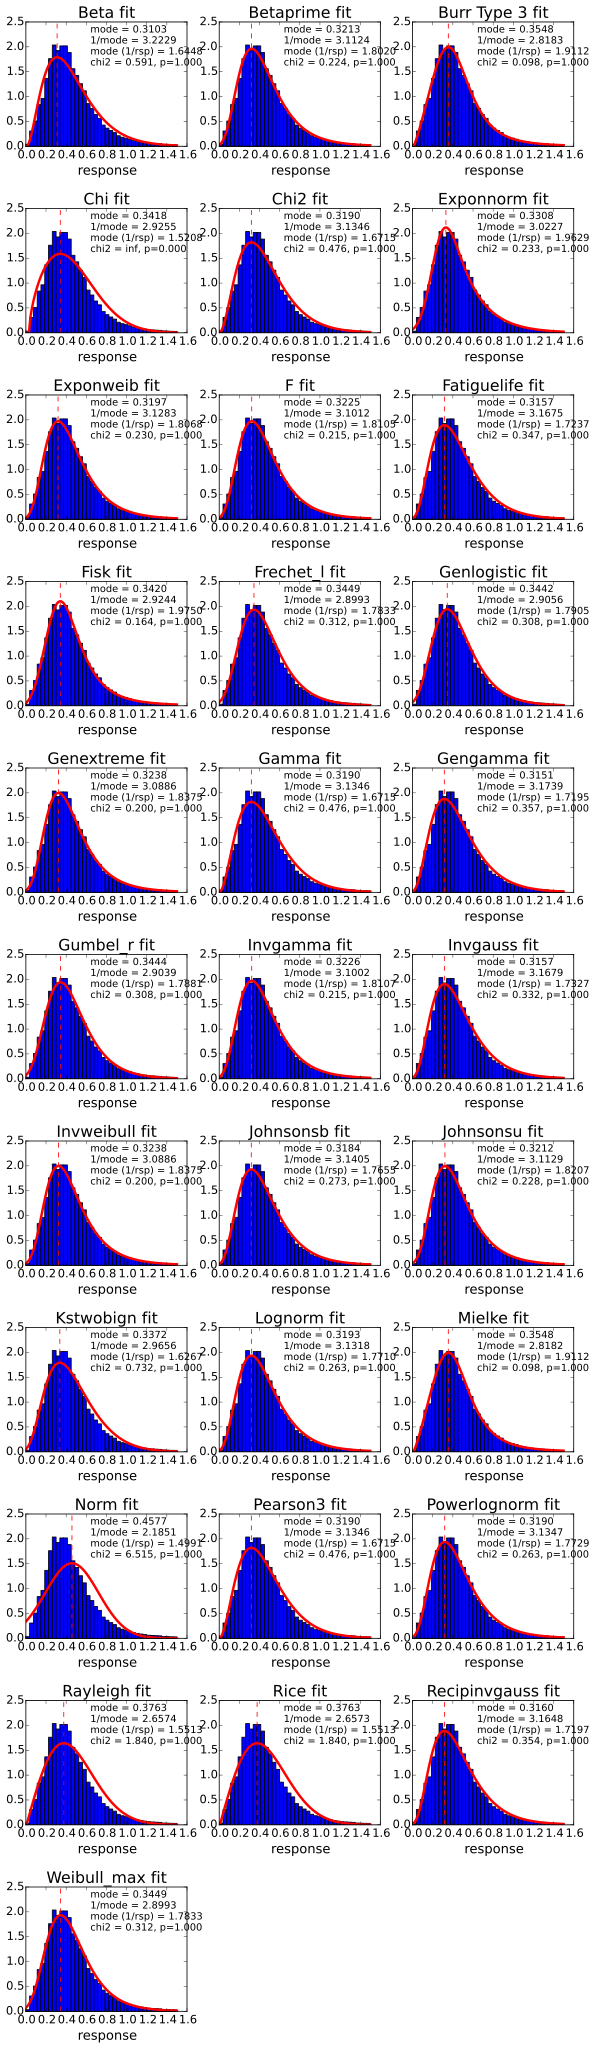

In [18]:
rspLow_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspLow, rspLow_fit_fns, 'response', [0, 1.5])

In [23]:
# plt.savefig('lowpT_rsp_multiple_fits.pdf')

Let's print out the fits ordered by the best $\chi^2$

In [93]:
def print_ordered_fit_fn(d):
    tmp = OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    print 'Function name : chi2 '
    for k, v in tmp.items()[:10]:
        print k, ':', v['chi2']


In [94]:
print_ordered_fit_fn(rspLow_fit_fns)

Function name : chi2 
Burr Type 3 : 0.0978116451796
Mielke : 0.0978159600107
Fisk : 0.16379384059
Genextreme : 0.200485971932
Invweibull : 0.200497670702
F : 0.215024069555
Invgamma : 0.215026342036
Betaprime : 0.22420666793
Johnsonsu : 0.228140502355
Exponweib : 0.230204187685


So the Burr (and Mielke) functions both look promising!

Let's plot the CDF to show off the differences and quality of fit:

In [28]:
def calc_hist_fn_diff(n, bins, fn):
    centers = get_bin_centers(bins)
    fn_vals = np.array([fn(x) for x in centers])
    return fn_vals - n

In [98]:
def plot_cdf(data, fit_fns, x_label, x_range, n_show=10):
    """Plot CDF for data compared with fit_fns. Also draws residuals plot.
    n_show controls how many to show. By default, it orders by ascending chi2.
    """
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    gs = gridspec.GridSpec(2, 1, height_ratios=[2.2, 1])
    gs.update(hspace=0.1)
    colormap = cm.gist_rainbow
    
    ax1 = fig.add_subplot(gs[0])

    tmp_fit_fns = OrderedDict(sorted(fit_fns.items(), key=lambda t: t[1])[:n_show])
    
    n, bins, _ = ax1.hist(data, normed=True, cumulative=True, bins=40, 
                          range=x_range, histtype='step', color='black', linewidth=2)
    bin_centers = get_bin_centers(bins)
    
    x = np.linspace(x_range[0], x_range[1], 100)
    colors = np.linspace(0, 1, int(n_show))
    diff_vals = []
    for color, (fn_name, fit_fn_dict) in izip(colors, tmp_fit_fns.iteritems()):
        loc=fit_fn_dict['loc']
        scale=fit_fn_dict['scale']
        if fit_fn_dict['shape']:
            fn_freeze = fit_fn_dict['fn'](*fit_fn_dict['shape'], loc=loc, scale=scale)
        else:
            fn_freeze = fit_fn_dict['fn'](loc=loc, scale=scale)
        y_vals = fn_freeze.cdf(x)
        diff_vals.append(calc_hist_fn_diff(n, bins, fn_freeze.cdf))
        ax1.plot(x, y_vals, color=colormap(color), linewidth=2, label=fn_name)                                                    
    ax1.legend(loc=4, fontsize=12)
    ax1.set_ylabel('CDF')
    
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    for color, diff in izip(colors, diff_vals):
        ax2.plot(bin_centers, diff, 'd-', color=colormap(color))
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('Fit - hist')
    ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], linestyle='dashed')
    ax2.grid(which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)        
       

Note that the Burr fit is hidden underneath the Mielke fit - they both give the same fit.

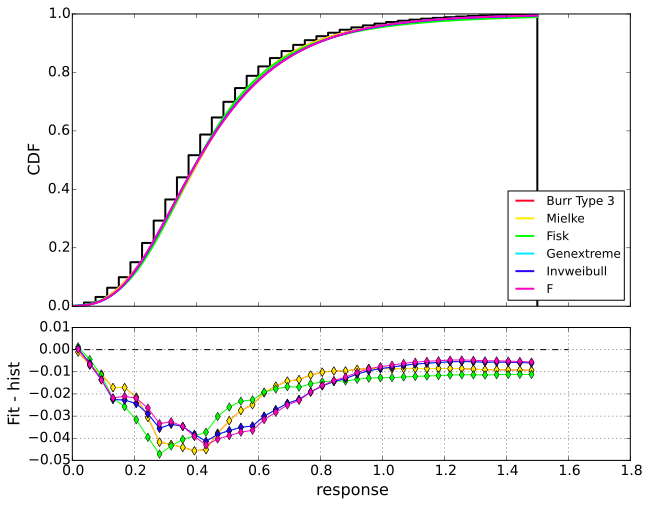

In [99]:
plot_cdf(rspLow, rspLow_fit_fns, 'response', [0, 1.5], n_show=6)

## 1 / response

Doing Beta
(1.5464057176090531, 57530.425713092292, 0.49989595424279998, 102735.83814050592)
(1.5464057176090531, 57530.425713092292) 0.499895954243 102735.838141 1.47565569954 0.214394232421 nan nan
Doing Betaprime


/Users/robina/.virtualenvs/L1JEC/lib/python2.7/site-packages/scipy/stats/stats.py:4376: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


(34.081921835496459, 3.7895868109746691, -0.06153832774798168, 0.25948925010943957)
(34.081921835496459, 3.7895868109746691) -0.061538327748 0.259489250109 1.7307681233 0.307665471785 0.12954734095 1.0
Doing Burr Type 3
(2.4933812341237327, 1.0795428977672512, 0.37423363940865045, 2.0031584574413754)
(2.4933812341237327, 1.0795428977672512) 0.374233639409 2.00315845744 1.87188287306 0.332605356684 nan nan
Doing Chi
(0.91656816143329745, 0.50001167527261747, 4.0849170647648254)
(0.91656816143329745,) 0.500011675273 4.08491706476 4.0 0.169511748049 nan nan
Doing Chi2
(3.4191275989512917, 0.49959989977113195, 0.78021083736103813)
(3.4191275989512917,) 0.499599899771 0.780210837361 1.60681924489 0.228783244282 nan nan
Doing Exponnorm
(5.6704556095259742, 1.1332564626787449, 0.35869932710778729)
(5.6704556095259742,) 1.13325646268 0.358699327108 1.68022714542 0.245822412914 0.225829871149 1.0
Doing Exponweib
(126.11313701067678, 0.38133902244432277, -0.018329640065858799, 0.0330572669579806

/Users/robina/.virtualenvs/L1JEC/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1543: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


(-3.7792166553948596, 8.3895570335147944)
None -3.77921665539 8.38955703351 2.39095173201 0.19424427591 1.63076789514 1.0
Doing Lognorm
(0.69502926870815163, 0.32052388303298784, 2.1790158832281099)
(0.69502926870815163,) 0.320523883033 2.17901588323 1.66473561428 0.281026040356 nan nan
Doing Mielke
(2.6916760490078535, 2.4933695161203611, 0.37424657095067371, 2.0031540961451983)
(2.6916760490078535, 2.4933695161203611) 0.374246570951 2.00315409615 1.8718797454 0.332605499905 nan nan
Doing Norm
(3.1672435827339647, 2.8594327767627186)
None 3.16724358273 2.85943277676 3.16724352388 0.168733713969 3.89456185708 0.999999999999
Doing Pearson3
(1.5296430149174833, 3.1672142387059505, 2.0402487857892191)
(1.5296430149174833,) 3.16721423871 2.04024878579 1.60678872533 0.228784536078 nan nan
Doing Powerlognorm
(0.2537167763962575, 0.38722405298954859, 0.090207912879439703, 1.3349256283175555)
(0.2537167763962575, 0.38722405298954859) 0.0902079128794 1.33492562832 1.66228599296 0.286067986605 0

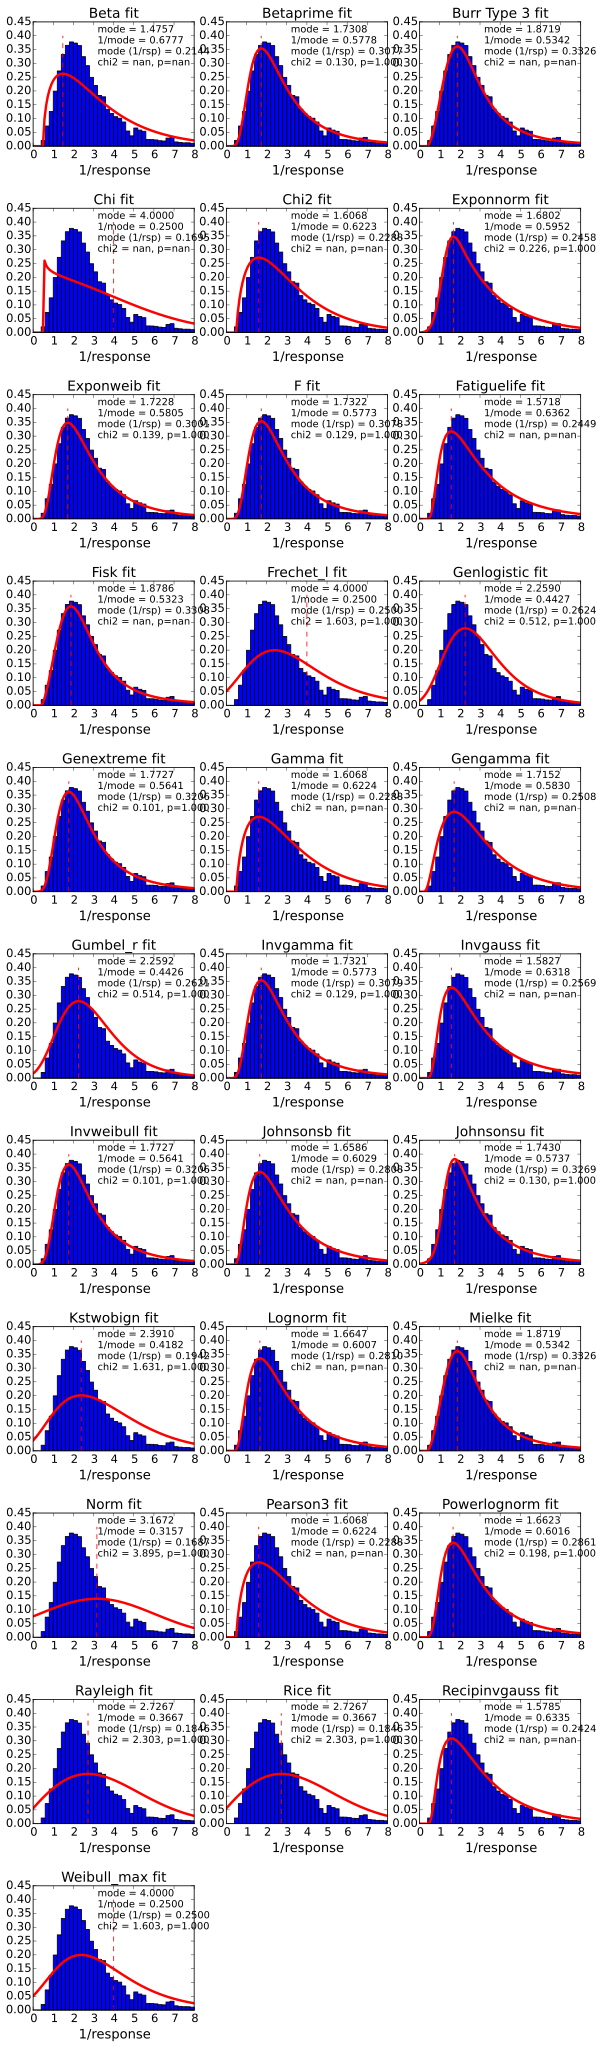

In [89]:
rspLowInv_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspLowInv, rspLowInv_fit_fns, '1/response', [0, 8])

None of these look particularly good (not as good as in response hists).

## Cross-check

We can check how well the distribution models response, by plotting it on top of 1/response (with necessary Jacobian transform) and calcualting chi2.

In [ ]:
def apply_fit_to_inverse(data, fit_fn, fn_name):
    """Fit to response, apply function (wiht jacobian) to inverse response."""
    plt.gcf().set_size_inches(14, 6)
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    
    # cuts for data
    mean = data.mean()
    std = data.std() * 10
    mask = (data < (mean+std)) & (data>(mean-std))
    
    n, bins, _ = ax.hist(data[mask], bins=40, range=[0, 1.5], normed=True)
    fit_results = fit_fn.fit(data[mask])
    shape = None
    loc = fit_results[-2]
    scale = fit_results[-1]
    if len(fit_results) >=3:
        shape = fit_results[0:-2]
    print shape, loc, scale
    # plot fitted fn
    x_val = np.arange(0.01, 1.5, 0.01)
    ax.plot(x_val, fit_fn.pdf(x_val, *shape, loc=loc, scale=scale), 'r', linewidth=3)
    ax.set_title('%s fit' % fn_name)
    ax.set_xlabel('response')

    # get mode
    max_result = minimize(lambda x: -1 * fit_fn.pdf(x, *shape, loc=loc, scale=scale), x0=0.75)
    mode = max_result.x[0]
    
    # do chi2 test
    bc = get_bin_centers(bins)
    predicted = fit_fn.pdf(bc, *shape, loc=loc, scale=scale)
    ddof = len(shape)+2
    chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=ddof)
    ax.text(0.5, 0.7, 'mode = %.4f\n1/mode = %.4f\nchi2 = %.4f\np = %.4f' % (mode, 1./mode, chisq, p), 
            transform=ax.transAxes)
    
    # plot 1/response
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    n, bins, _ = ax.hist(1./data, bins=40, range=[0,8], normed=True)
    x_val = np.arange(0.01, 8, 0.01)
    ax.plot(x_val, np.power((1./x_val), 2) * fit_fn.pdf(1./x_val, *shape, loc=loc, scale=scale), 
            'r', linewidth=3)

    # do chi2 test
    bc = get_bin_centers(bins)
    predicted = np.power((1./bc), 2) * fit_fn.pdf(1./bc, *shape, loc=loc, scale=scale)
    dof = 3
    chisq, p = scipy.stats.chisquare(n, f_exp=predicted, ddof=dof)
    
    ax.set_title('Using fit params')
    ax.set_xlabel('1 / response')
    mode = 1.0
    ax.text(0.5, 0.7, 'chi2 = %.4f\np = %.4f' % (chisq, p), transform=ax.transAxes)

(0.42484031636902841,) -0.124175829665 0.53119838748


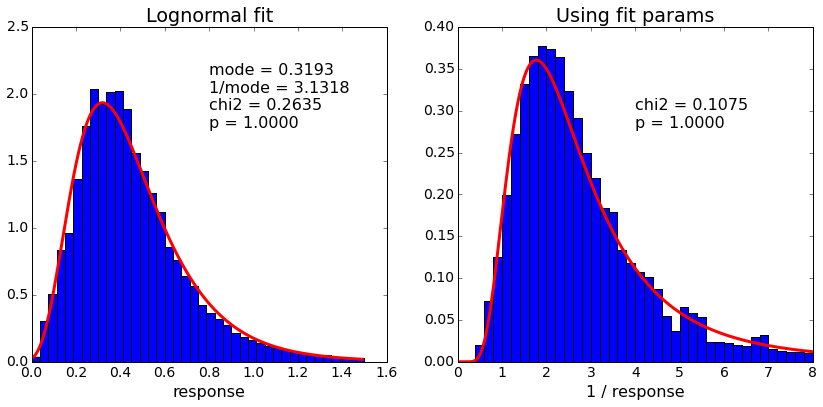

In [189]:
apply_fit_to_inverse(rsp, scipy.stats.lognorm, 'Lognormal')

(3.8624814633240279,) -0.08640309716 0.491336578023


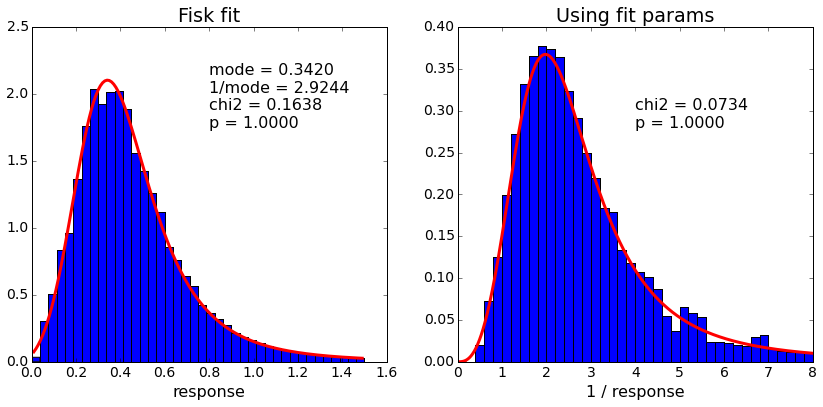

In [38]:
apply_fit_to_inverse(rsp, scipy.stats.fisk, 'Fisk')

(2.2999810196267463,) 0.217451928964 0.104436539053


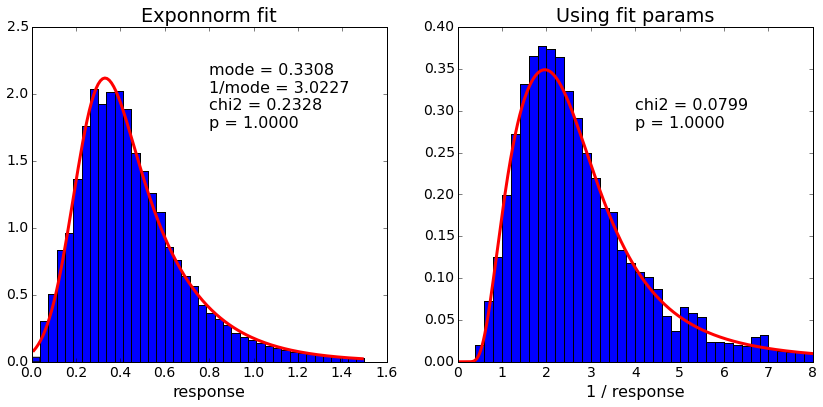

In [177]:
apply_fit_to_inverse(rsp, scipy.stats.exponnorm, 'Exponnorm')

(3.7989036602894894, 0.57362014248279913) 0.00912127339789 0.500232499187


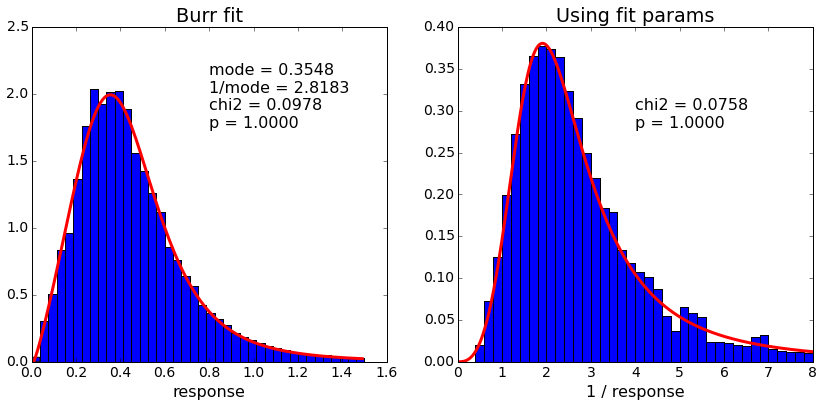

In [39]:
apply_fit_to_inverse(rsp, scipy.stats.burr, 'Burr')

This reinforces our belief that Burr does describe the data well.

## Higher ptRef bin (102 - 106 GeV)

Doing Beta
(27.627921563883277, 1876.4947154228075, -0.21949602920468314, 53.681175882775648)
(27.627921563883277, 1876.4947154228075) -0.219496029205 53.6811758828 0.531989729756 1.64571558527 7.0212762459 0.999999914071
Doing Betaprime
(108.07417236509849, 97.26478080922584, -0.48266578920599124, 0.9278029051891068)
(108.07417236509849, 97.26478080922584) -0.482665789206 0.927802905189 0.528314198499 1.66081967842 4.12541452624 0.99999999997
Doing Burr Type 3
(9.735131199234953, 0.71372751371132259, -0.13152277821839148, 0.71833840441299757)
(9.735131199234953, 0.71372751371132259) -0.131522778218 0.718338404413 0.544543818258 1.70133703157 0.193231977087 1.0
Doing Chi
(9.9014907005457964, -0.087650378980587432, 0.21095450730176082)
(9.9014907005457964,) -0.0876503789806 0.210954507302 0.541740110298 1.61845798211 56.7816311629 0.0150986400659
Doing Chi2
(58.999349670987954, -0.23743325161347356, 0.01350278292263286)
(58.999349670987954,) -0.237433251613 0.0135027829226 0.53221658534

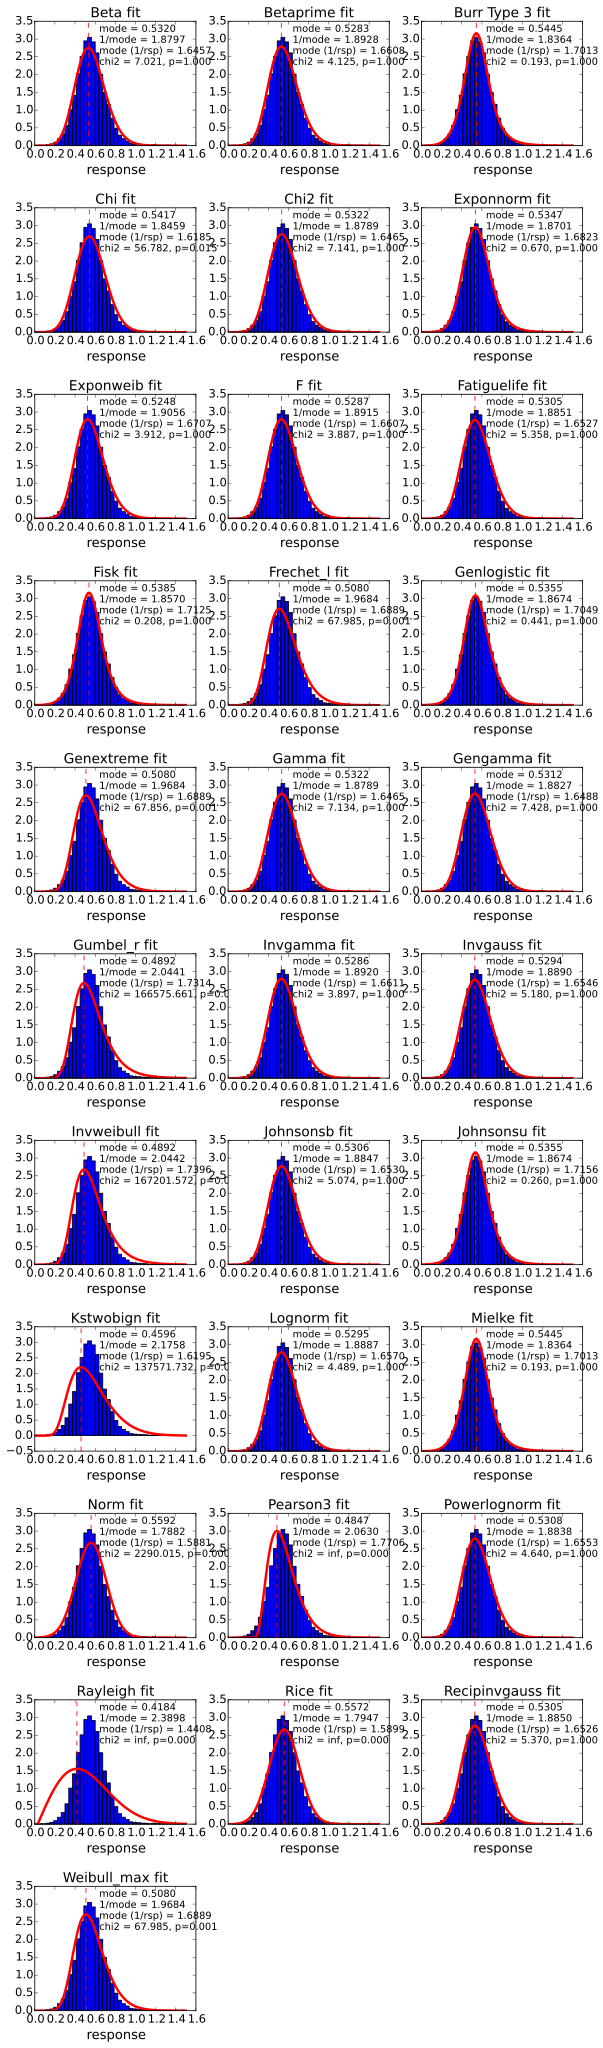

In [92]:
rspHigh_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspHigh, rspHigh_fit_fns, 'response', [0, 1.5])

In [ ]:
plt.savefig('highpt_rsp_multiple_fits.pdf')

In [95]:
print_ordered_fit_fn(rspHigh_fit_fns)

Function name : chi2 
Burr Type 3 : 0.193231977087
Mielke : 0.193234079093
Fisk : 0.207734287854
Johnsonsu : 0.260199190997
Genlogistic : 0.441079471134
Exponnorm : 0.669922284801
F : 3.88720434921
Invgamma : 3.89720751422
Exponweib : 3.9117761173
Betaprime : 4.12541452624


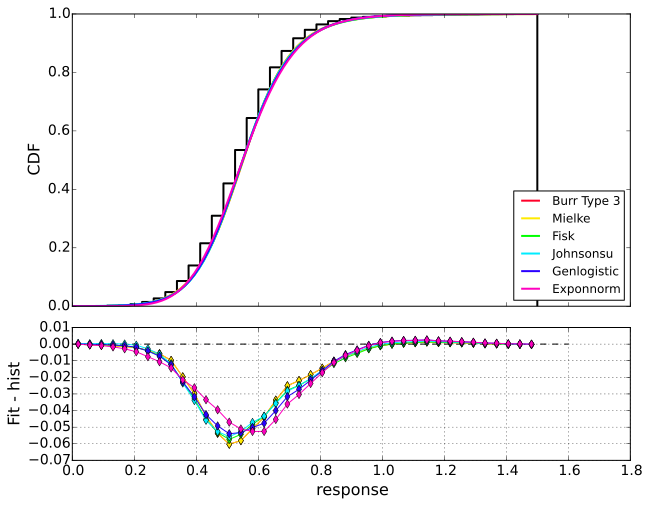

In [100]:
plot_cdf(rspHigh, rspHigh_fit_fns, 'response', [0, 1.5], n_show=6)

Doing Beta
(8.8577825313825933, 540223.85131551861, 0.29823673681485208, 99367.793197208797)
(8.8577825313825933, 540223.85131551861) 0.298236736815 99367.7931972 1.74356476015 0.485879498941 nan nan
Doing Betaprime
(49.340915713959546, 17.516576582192172, 0.090051083209346183, 0.61085825049838616)
(49.340915713959546, 17.516576582192172) 0.0900510832093 0.610858250498 1.68480859119 0.51598176411 nan nan
Doing Burr Type 3
(6.2241917100265418, 1.7183566253994096, -0.10561096121799055, 1.7201372582184706)
(6.2241917100265418, 1.7183566253994096) -0.105610961218 1.72013725822 1.69778865102 0.536978138919 0.139876229547 1.0
Doing Chi
(4.642519665385624, 0.30057461710232281, 0.79948156191366093)
(4.642519665385624,) 0.300574617102 0.799481561914 1.82641618351 0.464671540648 nan nan
Doing Chi2
(18.887831648166742, 0.29430787722832541, 0.086140532749723747)
(18.887831648166742,) 0.294307877228 0.0861405327497 1.74903498768 0.489240560851 nan nan
Doing Exponnorm
(1.9507960917332159, 1.43448178

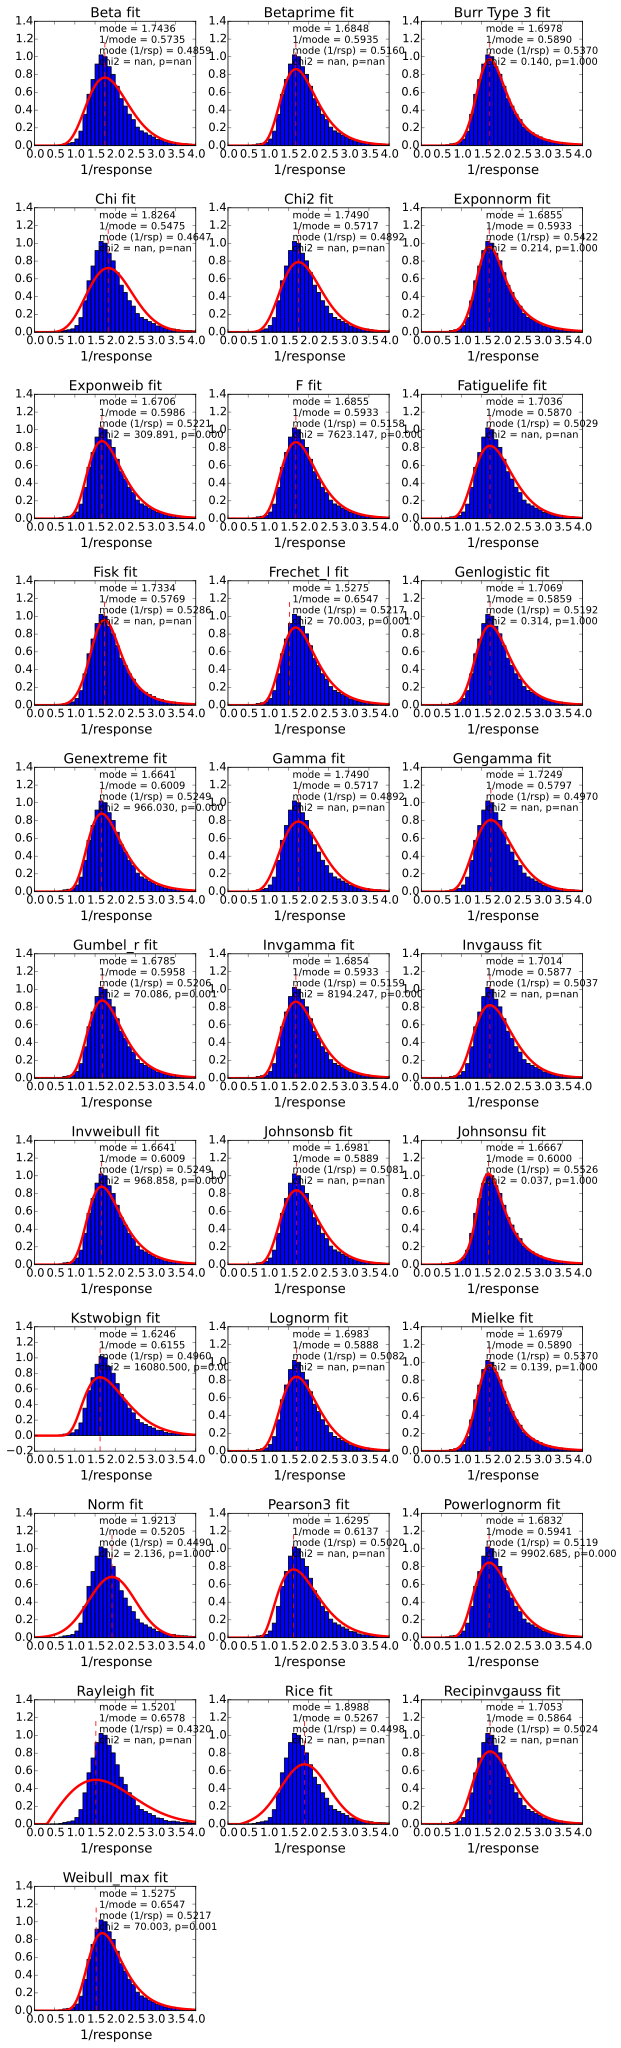

In [97]:
rspHighInv_fit_fns = deepcopy(fit_fns)
plot_multiple_fits(rspHighInv, rspHighInv_fit_fns, '1/response', [0, 4])

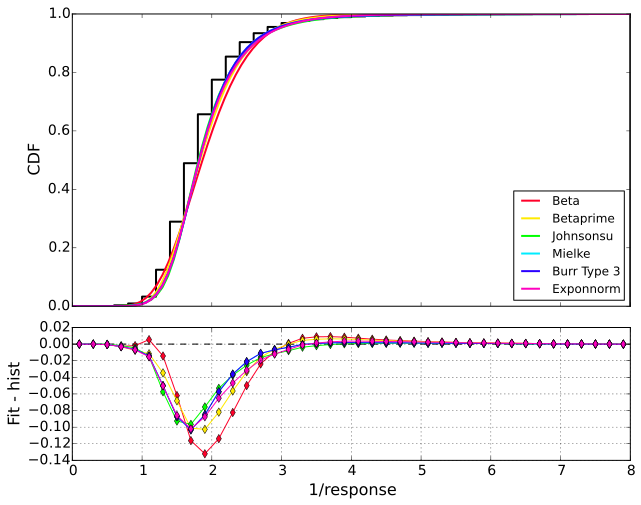

In [102]:
plot_cdf(rspHighInv, rspHighInv_fit_fns, '1/response', [0, 8], n_show=6)

Again repeat the check of applying the fit in response to the histogram of 1/response.

0.154298584152 -0.395180479058 0.943463158564


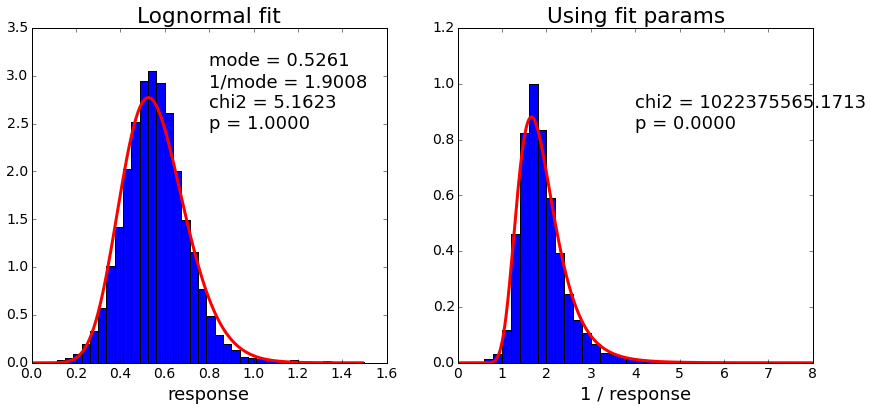

In [72]:
apply_fit_to_inverse(rspHigh, scipy.stats.lognorm, 'Lognormal')

13.0522913071 -0.488558211959 1.03842389756


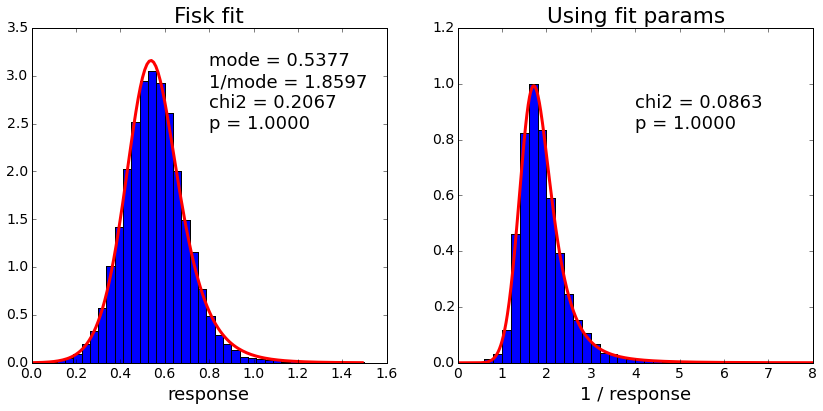

In [73]:
apply_fit_to_inverse(rspHigh, scipy.stats.fisk, 'Fisk')

(0.87557410318578643,) 0.463330557512 0.110058418106


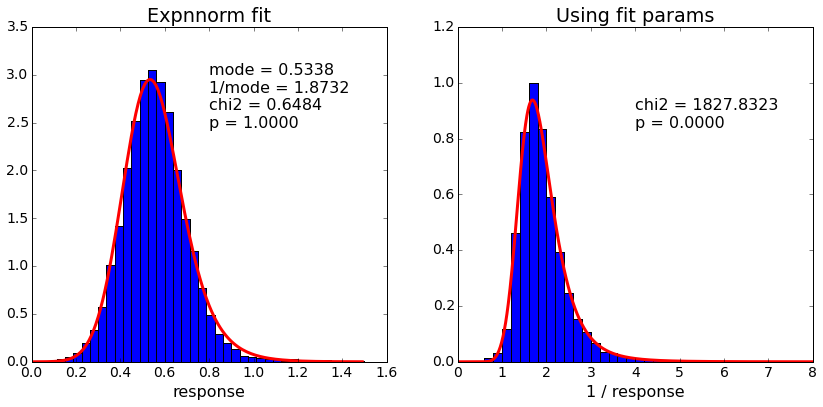

In [179]:
apply_fit_to_inverse(rspHigh, scipy.stats.exponnorm, 'Expnnorm')

(9.4933700313921499, 0.70746680887276558) -0.113873841711 0.701651954968


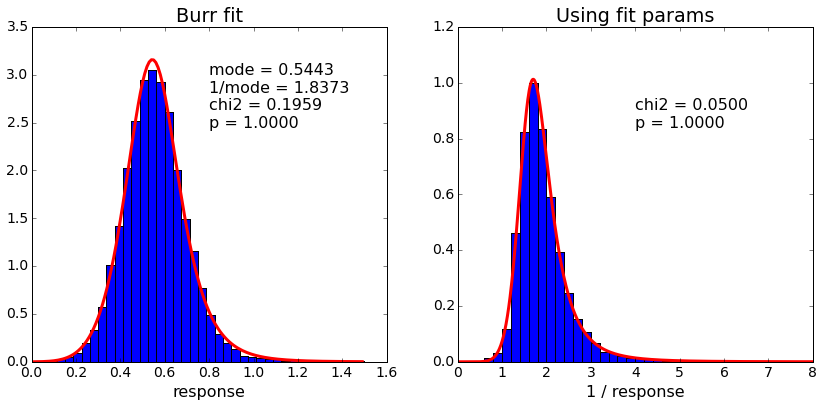

In [180]:
apply_fit_to_inverse(rspHigh, scipy.stats.burr, 'Burr')

# Conclusions

We have shown that a Burr type 3 is a very promising distribution for modelling the response in both low and high pT bins.